# INFO 204 Lab 8 - Unsupervised Learning I

***<span style='color: #ce2227;'>PLEASE READ ALL THE INSTRUCTIONS AND ACCOMPANYING TEXT IN LAB NOTEBOOKS - THE INFORMATION NEDED TO ANSWER A GIVEN TASK OR INTERPRET A GIVEN RESULT IS OFTEN IN THE TEXT!</span>***

In unsupervised learning, the goal is to develop a better understanding of the instances in our data, rather than making preditions about future unknown instances. This can involve many things, but in this lab you will specifically examine:
  1. Applying k-Means clustering to identify groups of similar instances in data
  2. Using clustering to relate feature values to subgroups of instances in data
  3. Dimensionality reduction through principal components analysis

## Precursors

For this lab, we will require the following libraries and components:

In [2]:
%env OMP_NUM_THREADS 1
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from pandas.plotting import parallel_coordinates

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from sklearn.datasets import make_blobs

env: OMP_NUM_THREADS=1


## Clustering

The basic concepts of clustering were covered in Lectures 15 and 16. Here, we demonstrate the application one clustering method, k-Means. First, we are going to need some data:

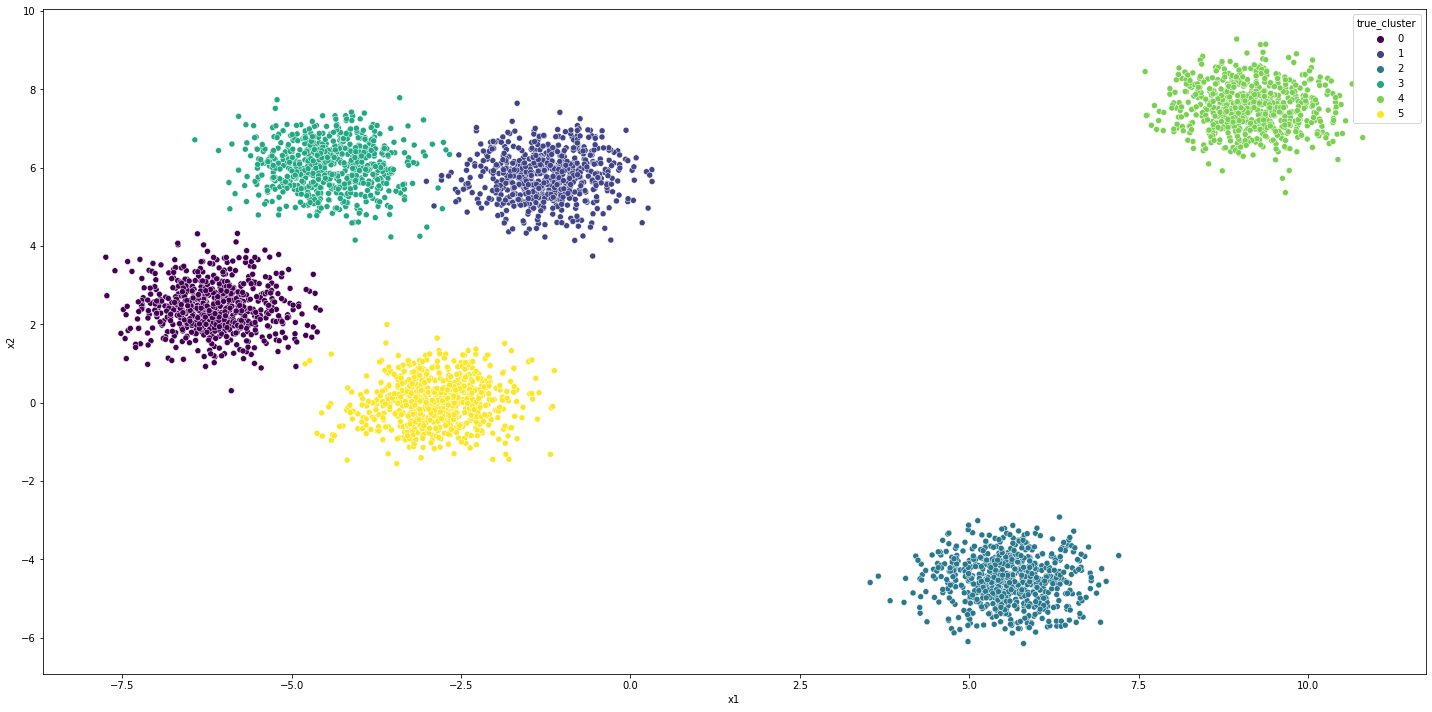

In [3]:
n_samples = 4000

X, t = make_blobs(n_samples=n_samples, centers=6, cluster_std=0.60, random_state=1234)
blobs = pd.DataFrame(X, columns=[ 'x1', 'x2' ])
blobs['true_cluster'] = t

fig = plt.figure(figsize=(20, 10))
sns.scatterplot(data=blobs, x='x1', y='x2', hue='true_cluster', palette='viridis')
plt.tight_layout()

Note that this data set contains a `true_cluster` variable - this is just bookkeeping for us to ease plotting and comparisons. For the sake of unsupervised learning `true_cluster` doesn't exist! 

### Applying k-Means

We start by applying k-Means clustering to our simple "blob" data under a range of different numbers of clusters. k-Means clustering requires us to declare upfront the number of clusters, and is generally best performed using standardised data. Although we could use a pipeline to do this, in this case it will be easier to standardise the data directly:

In [4]:
scaler = StandardScaler()
Z = scaler.fit_transform(X)

And then set up the k-Means clustering:

In [5]:
num_clusters = 6
cluster_model = KMeans(num_clusters, random_state=1234).fit(Z)

Here, we have parameterised k-Means to use 6 clusters. (we know that there are meant to be six!). Shortly, we will see if we can estimate this from the data.

We can identify which cluster an instance has been assiged to through the `labels_` attribute of the clustering model, which is an array containing the cluster ID for each instance in the order that they were presented for clustering:

In [6]:
C = cluster_model.labels_


Note that the order of the cluster IDs is arbitrary - the numeric value carries no semantic information or says anything about proximity of location of the clusters in space.

We can find the location of these clusters (the cluster centroids) as follows:

In [7]:
zcentroids = cluster_model.cluster_centers_       ## cluster centroids in the standardised space

Note that, because we standardise the data prior to clustering, the cluster centroids will be defined in the standardised space. If we wan them to be back in the space of the original data, we need to inverse transform (which is something that we never needed to do with supervised learning, but can be easily obtained by using the `inverse_transform` function of a `StandardScaler`):

In [8]:
centroids  = scaler.inverse_transform(zcentroids) ## cluster centroids translated back to original space


Finally, we can visualise the result of clustering:

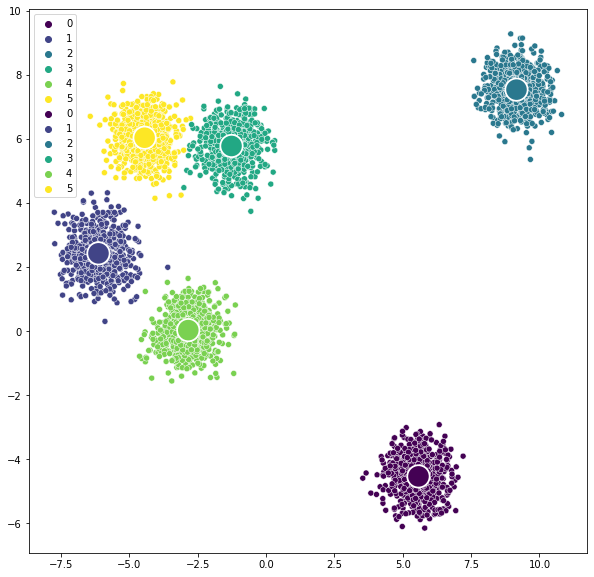

In [9]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=C, hue_order=range(num_clusters), palette='viridis')
sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], hue=range(num_clusters), hue_order=range(num_clusters), palette='viridis', s=500)
plt.show()

In this example, the large dots indicate the cluster centroids determined by k-Means. We obtained a very good result because we knew what the "right" number of clusters was. A question worth asking is: could we have estimated this "required" number of clusters from the data itself?

**<span style="color: #ce2227;">TASK 1: </span>** Explore the `n_clusters` hyperparameter of k-Means: using values 2 .. 10 (inclusive), run `KMeans` with the required number of clusters, and visualise the result of clustering. Use a 3x3 subplot arrangement for this (i.e., generate your plots within a figure created through `fig, axs = plt.subplots(3, 3, figsize=(15, 15))`)

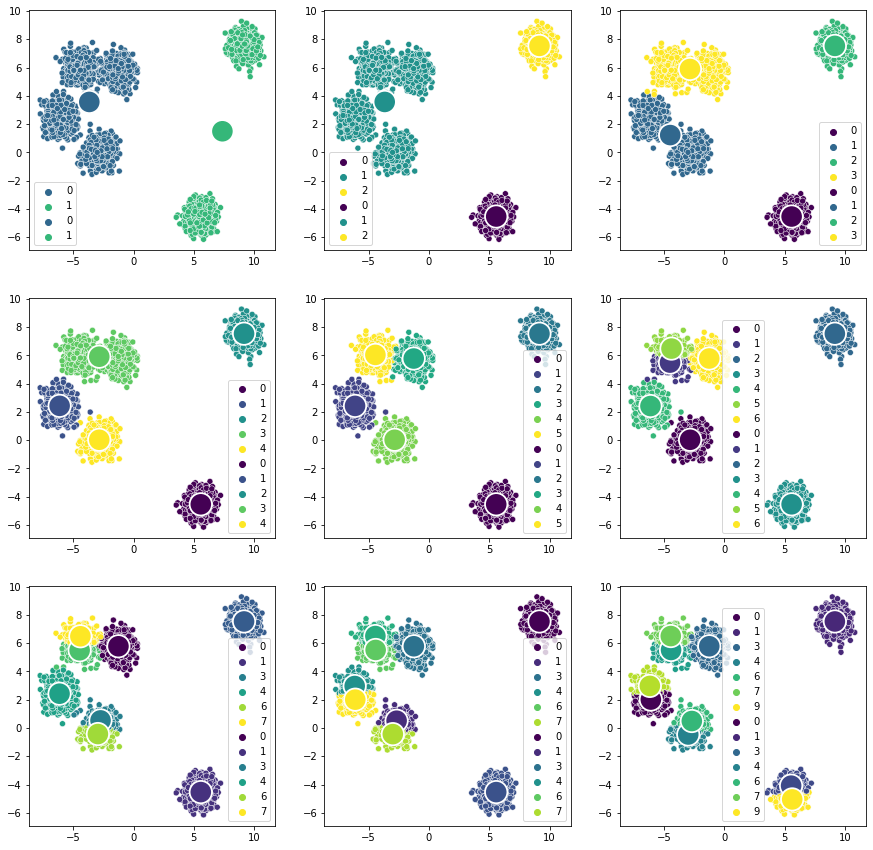

In [30]:
fig, axs = plt.subplots(3,3, figsize = (15,15))
N_clusters = [2,3,4,5,6,7,8,9,10]
count = 0
row = 0
for x in N_clusters:
    cluster_model = KMeans(x, random_state=1234).fit(Z)
    C = cluster_model.labels_
    zcentroids = cluster_model.cluster_centers_       ## cluster centroids in the standardised space
    centroids  = scaler.inverse_transform(zcentroids) ## cluster centroids translated back to original space
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=C, hue_order=range(x), palette='viridis',ax = axs[row, count])
    sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], hue=range(x), hue_order=range(x), palette='viridis', s=500, ax = axs[row, count])
    count +=1
    if (count == 3 ):
        row += 1
        count = 0


plt.show()

## Estimating the required number of clusters

The silhouette coefficient was discussed in Lecture 15 as an alternative to using WSS for identifying a suitable number of clusters for a given data set. This can be computed through scikit-learn through the `silhouette_score` function. Once again, let's build a k-Means model:

In [11]:
km = KMeans(6, random_state=1234).fit(Z)
C = km.labels_

We can obtain the silhouette coefficient for this model through the `silhouette_score` function. Note that we need the assigned cluster ids, and the _scaled_ instances:

In [12]:
s = silhouette_score(Z, C)
print(f'Silhouette Coefficient of k-Means using {num_clusters} clusters is: {s}')

Silhouette Coefficient of k-Means using 6 clusters is: 0.7415473866833893


**<span style="color: #ce2227;">TASK 2: </span>** Obtain silhouette coefficients for k-Means clustering applied to the blobs data using cluster sizes $k$ ranging from 2 to 10 (inclusive). Plot the relationship between $k$ and silhouette score, and determine the value of $k$ that will be selected:

<AxesSubplot:xlabel='cluster size', ylabel='ss'>

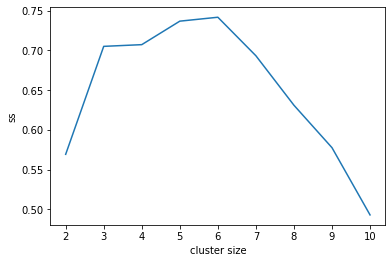

In [35]:
ssararay = []
for x in N_clusters:
    km = KMeans(x, random_state=1234).fit(Z)
    C = km.labels_
    s = silhouette_score(Z, C)
    ssararay.append(s)
df = pd.DataFrame({"cluster size": N_clusters,
"ss": ssararay})

sns.lineplot(data =df, x = "cluster size", y = "ss")


## Extracting Knowledge from Clusters

Clustering is a useful process for extracting knowledge. Once data is clustered, it is possible to inspect feature values to potentially explain what a typical instance in a cluster looks like. This may help to provide useful information to construct new features (e.g., to single out a specific cluster, we could create a new feature that is a threshold above a certain value that is unique to that cluster) or to simply inform what types of supervised learning might be well suited to the problem.

Let's start with a simple example of power consumption over a 24-hour time period (in kWh) for a range of households (in half-hour intervals):

In [37]:
power_data = pd.read_csv('power.csv', index_col=0, dtype={ 'time' : str, 'reading' : float }).pivot(columns='time', values='reading').reset_index()
display(power_data)
display(power_data.describe())

time,meter,0000,0030,0100,0130,0200,0230,0300,0330,0400,...,1900,1930,2000,2030,2100,2130,2200,2230,2300,2330
0,207860297,0.299,0.176,0.373,0.409,0.658,0.167,0.206,0.173,0.184,...,0.933,0.535,0.684,0.502,0.588,1.076,0.570,0.166,0.182,0.376
1,207860316,0.208,0.336,0.342,0.532,0.202,0.337,0.328,0.224,0.199,...,0.415,0.469,1.019,1.050,2.140,2.067,0.675,0.368,0.741,0.356
2,207860322,0.214,0.127,0.111,0.089,0.533,0.120,0.089,0.646,0.167,...,0.335,0.933,1.076,1.383,2.020,2.251,0.640,1.032,0.770,0.880
3,207860324,0.064,0.080,0.188,0.177,0.077,0.060,0.061,0.213,0.044,...,0.156,0.594,0.242,0.407,0.247,0.434,0.465,0.166,0.168,0.297
4,207860359,0.211,0.149,0.109,0.131,0.137,0.108,0.132,0.141,0.096,...,0.825,0.512,0.631,1.099,0.534,0.218,0.394,0.121,0.102,0.221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,RX07002650,0.373,0.162,0.160,0.160,0.160,0.158,0.160,0.158,0.096,...,0.632,0.557,0.600,0.902,0.365,0.184,0.184,0.162,0.160,0.201
237,RX07002658,0.186,0.608,0.172,0.180,0.166,0.168,0.176,0.170,0.166,...,0.546,1.082,1.998,0.820,0.598,0.538,0.190,0.194,0.168,0.634
238,RX07002666,0.121,0.296,0.739,0.129,0.138,0.136,0.127,0.138,0.278,...,0.330,0.286,1.499,0.816,0.520,0.147,0.127,0.111,0.115,0.123
239,RX07002668,0.484,0.420,0.368,0.616,0.194,0.194,0.200,0.232,1.198,...,0.860,0.926,0.320,0.422,0.584,0.300,0.296,0.466,0.490,0.668


time,0000,0030,0100,0130,0200,0230,0300,0330,0400,0430,...,1900,1930,2000,2030,2100,2130,2200,2230,2300,2330
count,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,...,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000
mean,0.220880,0.210183,0.199066,0.191058,0.201929,0.199228,0.186137,0.195668,0.208917,0.265763,...,0.595079,0.589859,0.606402,0.546680,0.561066,0.493689,0.390589,0.324685,0.259266,0.269515
std,0.207584,0.181840,0.155690,0.154473,0.161652,0.163405,0.145314,0.179077,0.214202,0.320141,...,0.466760,0.470442,0.481734,0.453994,0.490796,0.499051,0.372201,0.316048,0.238662,0.284371
min,0.026000,0.016000,0.016000,0.018000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.106000,0.104000,0.100000,0.096000,0.099000,0.100000,0.096000,0.095000,0.094000,0.096000,...,0.268000,0.253000,0.252000,0.228000,0.215000,0.182000,0.158000,0.128000,0.114000,0.112000
50%,0.156000,0.160000,0.148000,0.153000,0.151000,0.148000,0.145000,0.145000,0.146000,0.172000,...,0.445000,0.468000,0.454000,0.401000,0.387000,0.326000,0.250000,0.210000,0.180000,0.191000
75%,0.260000,0.242000,0.236000,0.226000,0.237000,0.250000,0.230000,0.230000,0.248000,0.308000,...,0.766000,0.762000,0.807000,0.727000,0.689000,0.606000,0.518000,0.390000,0.330000,0.308000
max,1.444000,1.262000,0.896000,0.986000,0.943000,1.060000,0.896000,1.454000,1.868000,2.333000,...,2.383000,2.785000,2.259000,2.653000,2.400000,2.892000,2.501000,1.758000,1.614000,2.636000


Note that, in this example, we will _NOT_ standardise the features, but will instead use the raw scales.

**<span style="color: #ce2227;">TASK 3: </span>**: Why have we decided that standardisation is not required for this example?

Values are all similar in size. So standardisation is not needed.

As mentioned in Lecture 17, we can use a parallel coordinates plot to visualise patterns in high-dimensional data. Let's look at the raw power data:

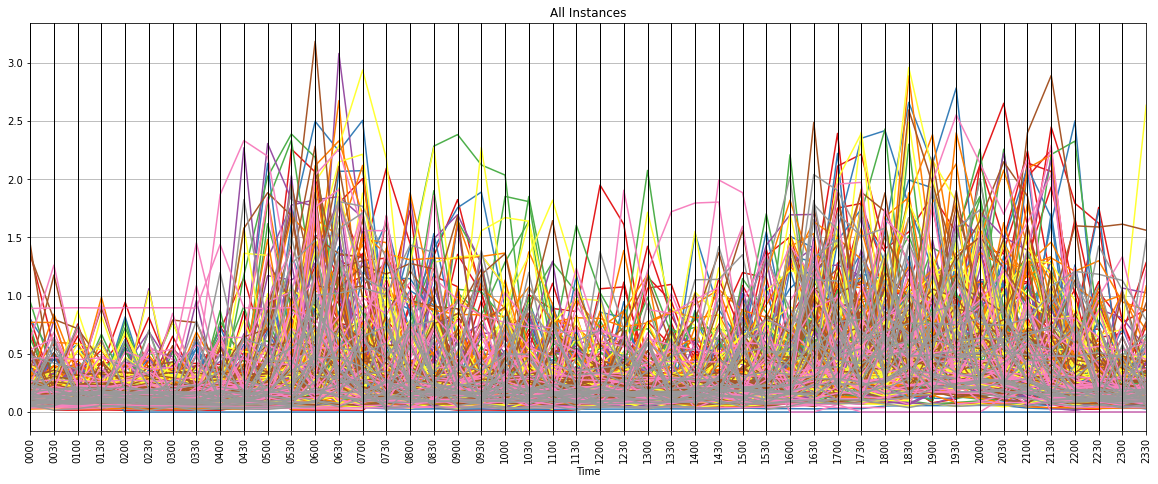

In [88]:
fig = plt.figure(figsize=(20, 7.5))
parallel_coordinates(power_data, class_column='meter', colormap='Set1')
plt.title('All Instances')
plt.gca().legend_.remove()
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.show()

It's difficult to see any useful trends in this data. Perhaps some clustering might help - let's apply k-Means to our data, and then colour the plot according to the cluster assigned to each instance:

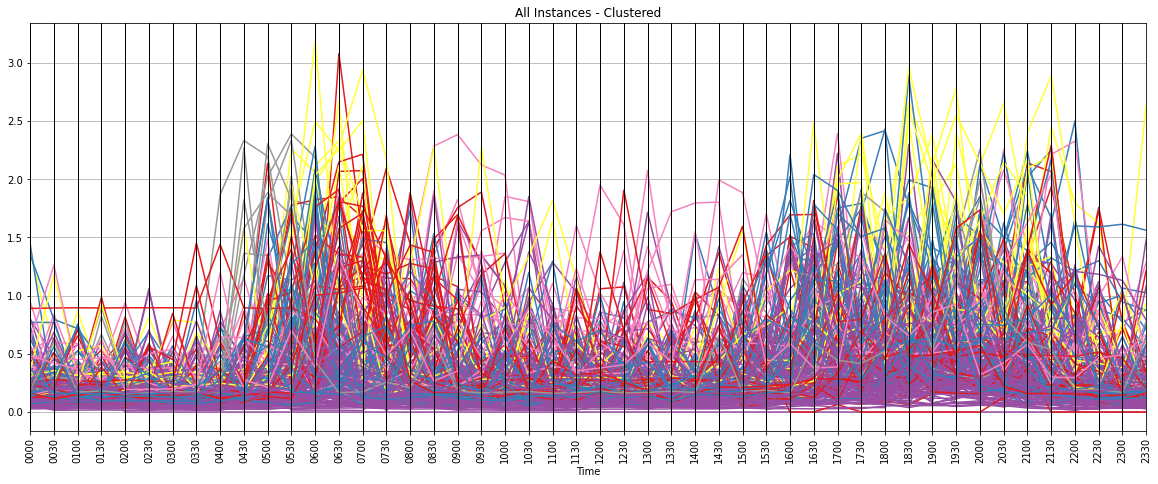

In [121]:
X = power_data.drop(columns='meter').to_numpy()
feature_names = power_data.drop(columns='meter').columns.values

num_clusters = 6

km = KMeans(num_clusters, random_state=1234).fit(X)

instance_data = pd.DataFrame(X, columns=feature_names)
instance_data['cluster'] = km.labels_

fig = plt.figure(figsize=(20, 7.5))
parallel_coordinates(instance_data, class_column='cluster', colormap='Set1')
plt.title('All Instances - Clustered')
plt.gca().legend_.remove()
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.show()

That's only slightly better (if at all!) - there's still too much data to be visualised properly. Perhaps, instead of plotting the instances themselves, we might see something if we plot the _cluster centres_:

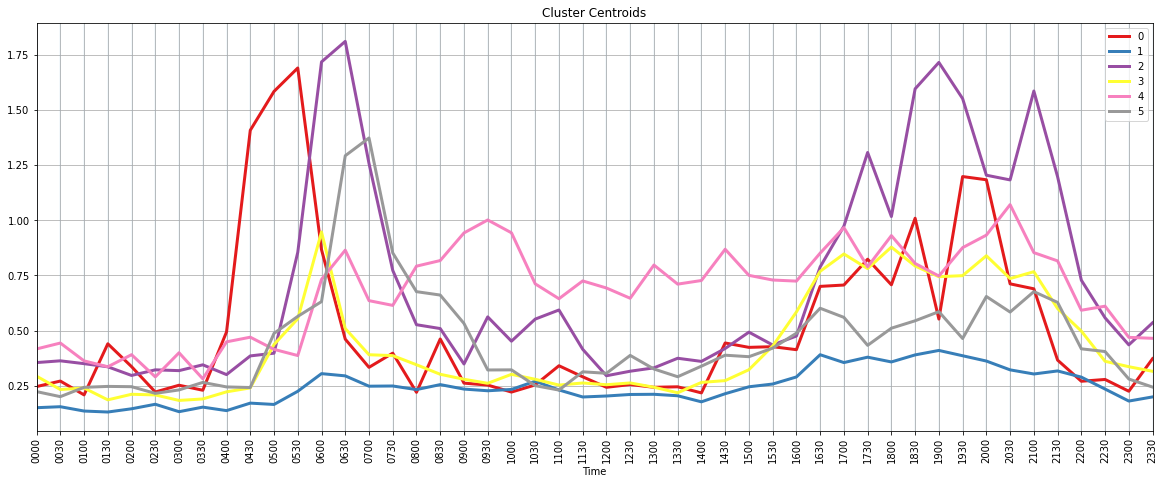

In [122]:
centroids = km.cluster_centers_
centroid_data = pd.DataFrame(centroids, columns=feature_names)
centroid_data['cluster'] = range(num_clusters)

fig = plt.figure(figsize=(20, 7.5))
parallel_coordinates(centroid_data, class_column='cluster', colormap='Set1', linewidth=3, axvlines_kwds={ 'linewidth' : 0.1 })
plt.title('Cluster Centroids')
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.show()

This is starting to show clear differences, but the colour map is still somewhat distracting. We could play around with the colours, but this has an element of subjectivity to it. Alternatively, we could isolate each cluster centre and plot in its own subplot:

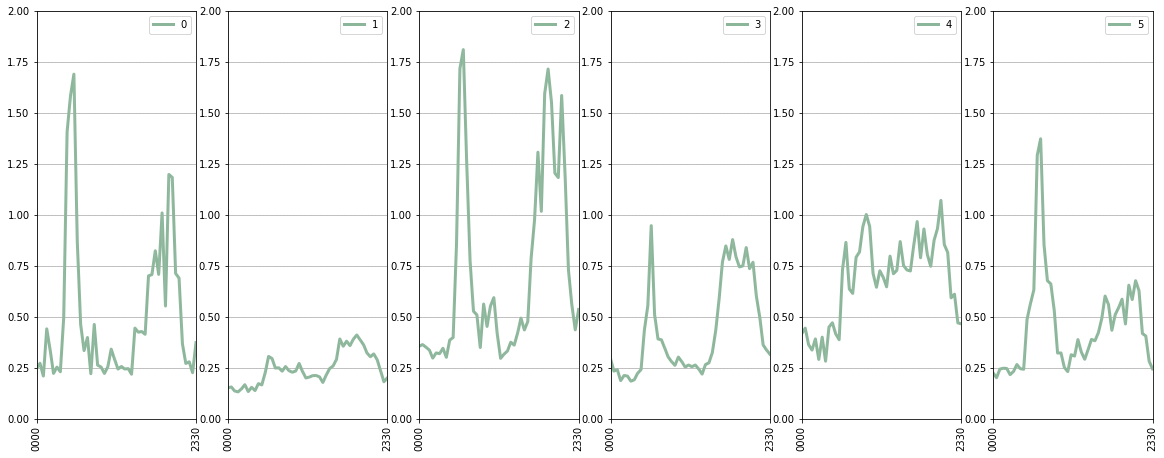

In [123]:
fig = plt.figure(figsize=(20, 7.5))

for cluster in range(num_clusters):
    fig.add_subplot(1, 6, cluster+1)
    parallel_coordinates(centroid_data.loc[[cluster]], class_column='cluster', linewidth=3, axvlines_kwds={ 'color' : 'white', 'linewidth' : 0.1 })
    plt.ylim(0, 2)
    idx, labels = plt.xticks()
    plt.xticks([ idx[0], idx[-1]], [ labels[0], labels[-1] ], rotation=90)
plt.show()

**<span style="color: #ce2227;">TASK 4: </span>**: Broadly characterise the six "demographics" identified by k-Means clustering.

There are different types of clusters of energy users. You can one , 3 and 5 which seem to have peaks in the morning and peas at night whilst keeping a low energy usage throughout the day. heights of peaks may be determined by age of children and number of people in the households with teenagers havingmore use of power compared to kids. You can be kike 2 which is somebody you'd assume to be old and doesnt use much power. 5, Somebody who uses more power throughout the day maybe lives in a hot place where the later it goes the more coooling is needed. Or 6 with high peak at noon and climbs up towards the night but doesnt use as much energy.

**<span style="color: #ce2227;">TASK 5: </span>**: Rather than specify a number of cluster in advance, use silhouette analysis to identify potential numbers of clusters to use. Explore between 2 and 10 clusters (inclusive). Plot the relationship between $k$ and silhouette score, and determine the value of $k$ that will be selected. Plot a parallel coordinates plot for the "best" identified number of clusters:

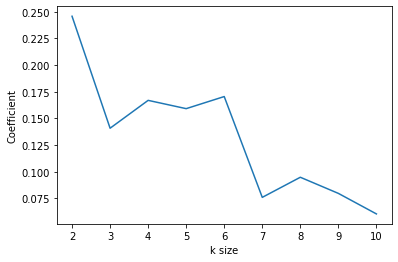

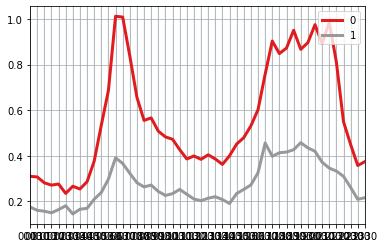

In [146]:
clusters = [2,3,4,5,6,7,8,9,10]
silCof = []
for x in clusters:
    km = KMeans(x, random_state=1234).fit(X)
    C = km.labels_
    s = silhouette_score(X, C)
    silCof.append(s)
df = pd.DataFrame({"k size" : clusters, 
                  "Coefficient" : silCof})
best = df[df['Coefficient'] == df["Coefficient"].max()]['k size'].values[0]
km1 = KMeans(best, random_state=1234).fit(X)
C1 = km1.cluster_centers_

centroidData = pd.DataFrame(C1, columns = feature_names)
centroidData['cluster'] = range(best)

sns.lineplot(data = df, x = "k size", y = "Coefficient");
plt.show()

parallel_coordinates(centroidData, class_column='cluster', colormap='Set1', linewidth=3, axvlines_kwds={ 'linewidth' : 0.1 })
plt.show()
#Best number of clusters is 2




**<span style="color: #ce2227;">TASK 6: </span>**: In the previous task, you should find that the "best" number of clusters is 2. Based on the parallel coordinates plot, what might these clusters represent in terms of customer behaviour? Why might we then choose to cluster based on the _next best_ clustering identified by silhouette analysis?

General expidure wouod be used high in the morning maybe to watch the news and stuff that happened over night and then once again will be high in the evening for rest time after school/work. We may choose to clster on the next best clustering identified by the silhoeuette might be to get the next most popuular life style and with their uses.

## Dimension Reduction and Principal Components Analysis

The basic concepts of PCA were covered in Lecture 17. Here, we demonstrate the application of PCA to the California Housing data set. As mentioned in lectures, scaling can have a big impact on the resulting projection produced by PCA, so this will be an important part of your analysis.

As always, there's a few things that we need to import:

In [147]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.datasets import fetch_california_housing

### Helper Functions

We also provide a few helper routines to simplify the presenting of the results of PCA - check the notebook that is attached to Lecture 17 for more information on these:

In [148]:
def extract_loadings(pca, feature_names=None, pipeline_component=None, prefix='PC'):
    if pipeline_component is not None:
        pca = pca[pipeline_component]
        
    X = pca.components_.T
    
    return pd.DataFrame(X, columns=[ f'{prefix}{i+1}' for i in range(X.shape[1]) ], index=feature_names)

def biplot(X, loadings=None, pc1=0, pc2=1, y=None, labels=None):
    xs = X[:, pc1]
    ys = X[:, pc2]
    
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())    
    sns.scatterplot(x=xs*scalex, y=ys*scaley, hue=y, palette='viridis')
    
    if loadings is not None:
        n = len(loadings)
        if labels is None:
            labels = loadings.index.values
        for i in range(n):
            plt.arrow(0, 0, loadings.iloc[i, pc1], loadings.iloc[i, pc2], color='#ce2227', width=0.01, head_width=0.04)
            plt.text(loadings.iloc[i, pc1]* 1.15, loadings.iloc[i, pc2] * 1.15, labels[i], color='#ce2227', ha='center', va='center')
        
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel(f'PC{pc1+1}')
    plt.ylabel(f'PC{pc2+1}')
    plt.grid()

def screeplot(pca, pipeline_component=None, prefix='PC', n_components=None):
    import seaborn as sns
    from matplotlib import pyplot as plt
    
    if pipeline_component is not None:
        pca = pca[pipeline_component]

    explained_variance = pca.explained_variance_ratio_
    if n_components is not None: explained_variance = explained_variance[0:n_components]
    
    total_variance = np.cumsum(explained_variance)
    ticks = range(len(explained_variance))
    labels = [ f'{prefix}{i+1}' for i in ticks ]

    plt.bar(x=range(len(explained_variance)), height=explained_variance, label='Component')
    plt.plot(range(len(total_variance)), total_variance, 'o-', color='#ce2227', linewidth=2, label='Cumulative')
    plt.xticks(ticks=ticks, labels=labels)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance')
    plt.legend()


Let's start by loading the data:

In [149]:
housing = fetch_california_housing(as_frame=True)

data = housing['data'].drop(columns=[ 'Latitude', 'Longitude' ])
feature_names = data.columns.values

X = data.to_numpy()
t = housing['target'].to_numpy()

display(data.describe())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333


**<span style="color: #ce2227;">TASK 7: </span>**: Are there potential issues with scale in this data set? If so, in 1-2 sentences, describe these potential issues.

House age and population are bigger than the other factors especially Population with an average of over 1000 excluding houseage everything else being lower than 10,

**<span style="color: #ce2227;">TASK 8: </span>**:  Produce a scatter plot of the two most variant features in the data set:

<AxesSubplot:xlabel='HouseAge', ylabel='Population'>

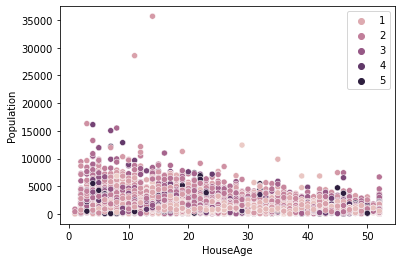

In [150]:
sns.scatterplot(data=data, x='HouseAge', y='Population', hue=t)

It's probably also a good idea to visualise the correlations and pairwise plots of features:

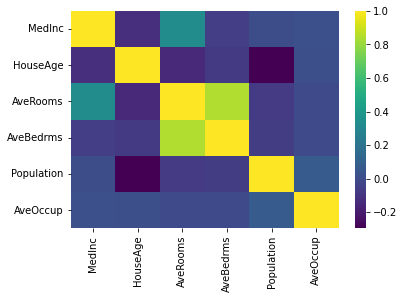

<Figure size 360x360 with 0 Axes>

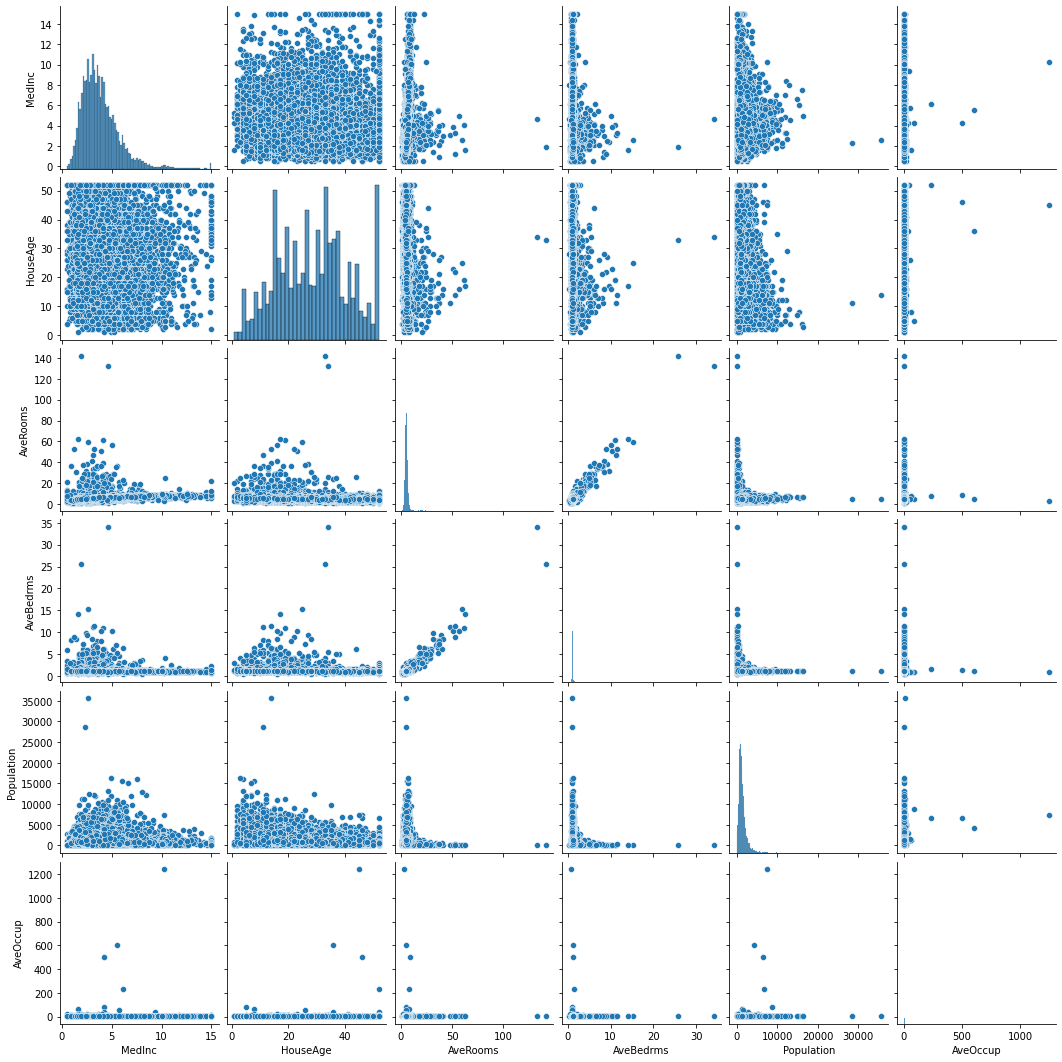

In [151]:
sns.heatmap(data.corr(), cmap='viridis')

fig = plt.figure(figsize=(5, 5))
sns.pairplot(data);

### Performing PCA

Let's now perform PCA on this data set and examine the results:

In [152]:
pca = PCA()
P = pca.fit_transform(X)

The above code will perform a complete PCA on the provided data, and return a transformed variant of the data in `P` (with each column in `P` corresponding to a principal component identified by PCA). Let's plot `P` to see the result of applying PCA:

<Figure size 360x360 with 0 Axes>

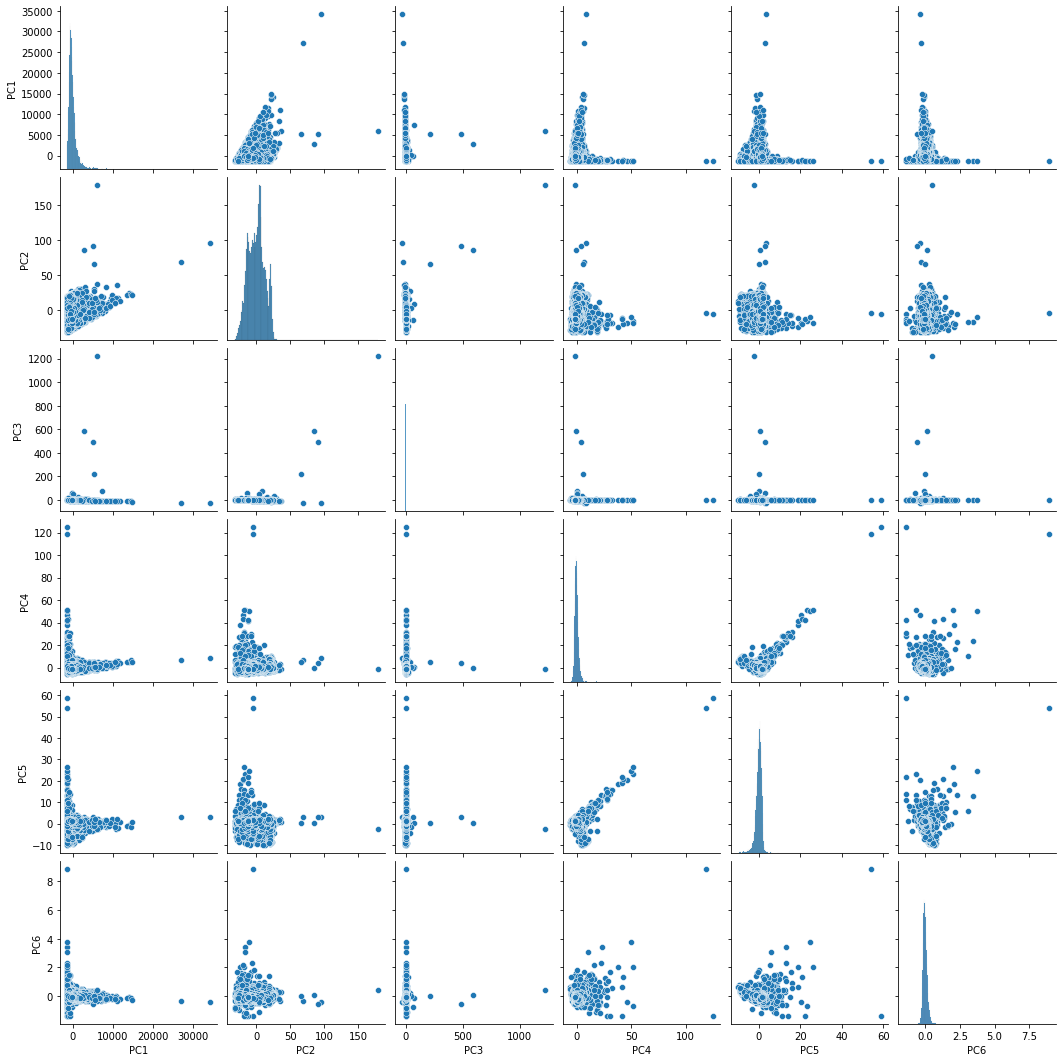

In [153]:
fig = plt.figure(figsize=(5, 5))
sns.pairplot(pd.DataFrame(P, columns=[ f'PC{i+1}' for i in range(len(feature_names)) ]));

You might want to look closely at these results. In particular, how "different" are identified principal components versus the original features?

Checking the loadings of each principal component provides more insight on the usefulness of PCA here:

,PC1,PC2,PC3,PC4,PC5,PC6
MedInc,0.000008,-0.019820,0.006737,0.410135,-0.906965,0.093627
HouseAge,-0.003293,0.992309,-0.115393,0.044604,-0.002495,-0.001185
AveRooms,-0.000158,-0.039020,0.006388,0.901490,0.389516,-0.184473
AveBedrms,-0.000028,-0.004237,0.000613,0.130782,0.160235,0.978367
Population,0.999994,0.003187,-0.001015,0.000292,0.000063,-0.000007
AveOccup,0.000641,0.115672,0.993276,-0.003478,0.003258,-0.000190


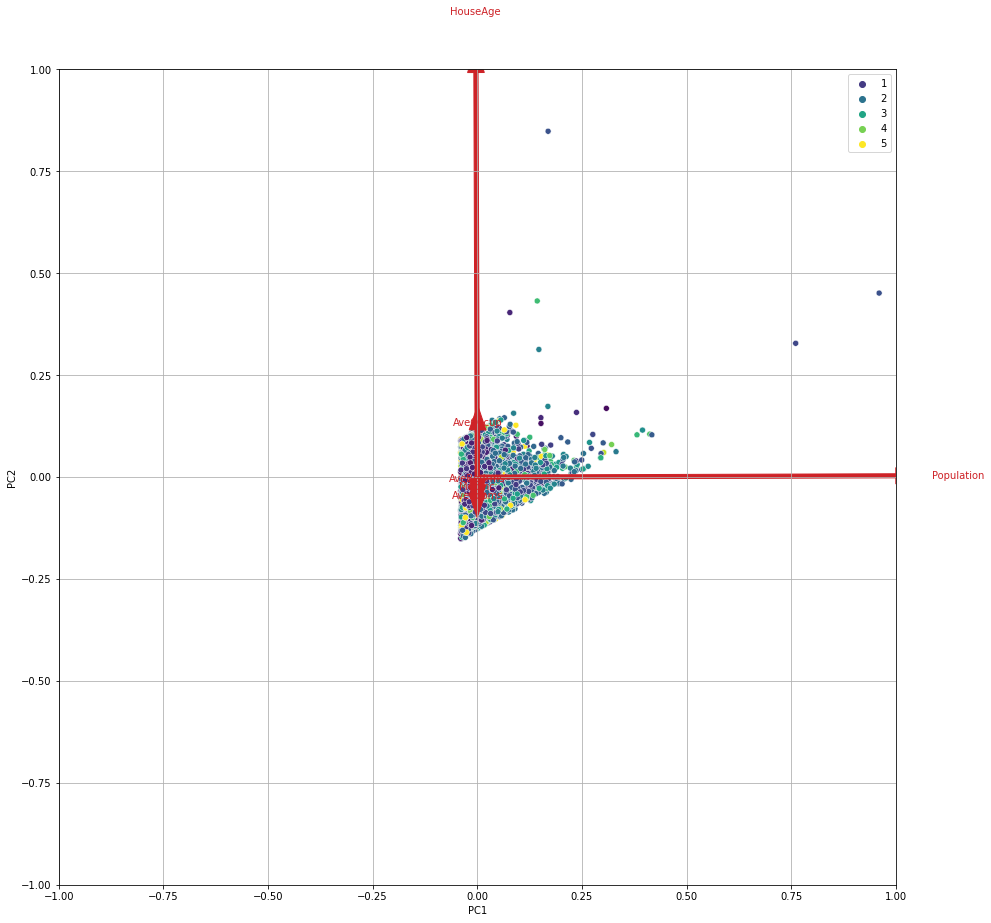

In [154]:
display(extract_loadings(pca, feature_names=feature_names))

fig = plt.figure(figsize=(15, 15))
biplot(P, extract_loadings(pca, feature_names=feature_names), y=t)
plt.show()

Finally, a screeplot will help us understand the variance explained by each of the principal components:

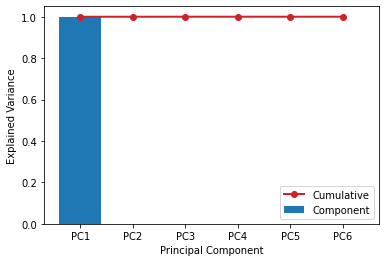

In [155]:
screeplot(pca)

**<span style="color: #ce2227;">TASK 9: </span>**: Briefly comment on the result of PCA on this data set. In particular, are there any clear relationships between the principal components and the original features (hint: look at the loadings). Finally, suggest a reason for the performance of PCA as shown here on this data set.

PC1 is hugely dominated by population which is by far the biggest numbers due to the high variance. Followed by p2 because House age is 2nd in highest variance. The reason for the performane of the PCA is due to the lack of scaling and the big variance values affecting the PCA heavily.

**<span style="color: #ce2227;">TASK 10: </span>**: Repeat the above PCA analysis, but this time include feature scaling in your work. _Use a pipeline to achieve this_:

,PC1,PC2,PC3,PC4,PC5,PC6
MedInc,0.228031,0.240443,-0.883536,0.024702,0.165311,0.285683
HouseAge,-0.186531,-0.650329,-0.098534,0.215187,0.696671,-0.030242
AveRooms,0.703455,-0.052145,-0.040715,0.029307,0.094443,-0.700711
AveBedrms,0.645461,-0.170953,0.347031,0.035639,0.079649,0.652772
Population,-0.040706,0.683752,0.294319,0.006454,0.666189,-0.018790
AveOccup,-0.009076,0.140707,0.030718,0.975148,-0.168081,-0.003236


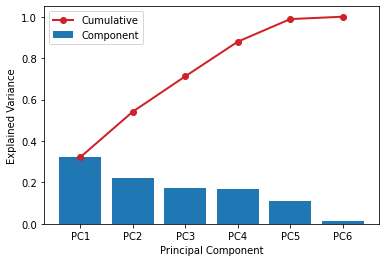

In [179]:
pipe = Pipeline([('scaler', StandardScaler()),
 ('pca',PCA())
])
p = pipe.fit_transform(X)
display(extract_loadings(pipe['pca'], feature_names=feature_names))
screeplot(pipe['pca'])

**<span style="color: #ce2227;">TASK 11: </span>**: In the previous task, why did we ask you to apply scaling through a pipeline, rather than simply apply standardisation "offline" directly to the data? (hint: in the second assignment, we will ask you to include PCA as a step within a supervised learning task)

If we want to replicate the data we then would just need the pipe instead of typing the code out again for each of the cases. This saves time and is just more efficient.

**<span style="color: #ce2227;">TASK 12: </span>**: Contrast the PCA projection that you've just completed against the one performed without standardisation. If you were now going to use the principal components for modelling in supervised learning, how many principal components would you use (and why)? How might you more rigorously identify the number of principal components to use?

you would just use up to PC 4 which accounts to 80% of the variance which is enough. You would identify which ones to use by the largest pc's up to 80% summed.

### Using PCA in Supervised Learning

It's possible to include PCA within the process of supervised learning - we simply apply PCA (after standardisation), select the required number of components, and then build the model. Let's look at one way of doing this - in the second assignment, you will do this in a more rigorous fashion using pipelines and cross validation.

To keep things simple, let's just get a testing and training partition of our California Housing data:

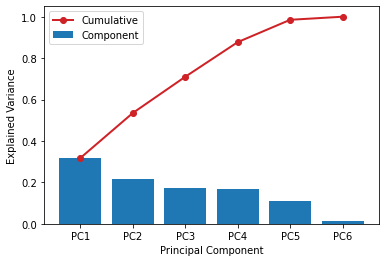

In [157]:
from sklearn.datasets import fetch_california_housing

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

housing = fetch_california_housing()
X = housing['data'][:, 0:-2] ## drop latitude and longitude
t = housing['target']

scaler = StandardScaler()
pca = PCA()

X_train, X_test, t_train, t_test = train_test_split(X, t, train_size=0.5, random_state=1234)
Z_train, Z_test = scaler.fit_transform(X_train), scaler.transform(X_test)
P_train, P_test = pca.fit_transform(Z_train), pca.transform(Z_test)

screeplot(pca)

**<span style="color: #ce2227;">TASK 13: </span>**: declare an empty list called `perf`. Write a for loop that iterates from 1 to the number of principal components (hint: this is equal to the number of features). Within in the loop, extract the first n principal components from `P_train` and `P_test` (e.g., P_train[:, 0:n]), and fits a `LinearRegression` model on `P_train[:, 0:n]` and `t_train`. Compute the test mean squared error of this model using `P_test[:, 0:n]` and `t_test`, and then append a dictionary to `perf` with the entries `'n_comp' : n` and `'MSE' : mse`.

After the loop has completed, convert `perf` into a pandas data frame (i.e., `perf = pd.DataFrame(perf)`).

In [221]:
perf = []
for x in range(len(feature_names)):
    pt = P_train[:, 0:x + 1]
    t = P_test[:, 0:x + 1]
    ln = LinearRegression().fit(pt, t_train)
    mse = mean_squared_error(t_test, ln.predict(t))
    perf.append({'n_comp': x + 1, "MSE": mse})
    
perf = pd.DataFrame(perf)



If you have completed the above task correctly, then the following cell should generate a line plot of the mean squared error performance for a given number of principal components:

0.6160866346398252


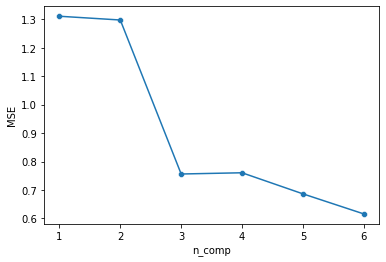

In [222]:
sns.lineplot(data=perf, x='n_comp', y='MSE')

sns.scatterplot(data=perf, x='n_comp', y='MSE')

mdl = LinearRegression().fit(Z_train, t_train)
print(mean_squared_error(t_test, mdl.predict(Z_test)))

**<span style="color: #ce2227;">TASK 14: </span>**: Comment of the performance of performing supervised learning using principal components.

adding more numbers of comp will decrease the amount of MSE but the trade off would be more computationally expensive. So 3 is a good trade off for the lowering of mse and the number of principle componendts.

**<span style="color: #ce2227;">TASK 15: </span>**: In the second assignment you will be asked to perform this type of supervised learning using cross validation and pipelines. Briefly comment on how you might set up a pipeline for choosing the number of principal components

we would create a pipeline that test the score of each number of priciple components and record the score. Then choose the number of principle components based on the highest score.